In [1]:
import random
import imutils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf
import keras
print(tf.config.list_physical_devices('GPU'))

import cv2

/tmp/ipykernel_3712/738579589.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-01 12:10:43.279948: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 12:10:43.280010: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 12:10:43.281439: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-02-01 12:10:47.337212: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-01 12:10:47.377623: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-01 12:10:47.380042: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

(32, 32)


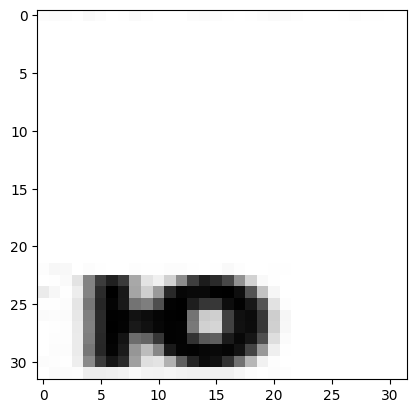

In [2]:
let = cv2.imread('data/letterlist.jpg', 0)
let = let[15:780,:]
num_letters = 33
num_fonts = 21
num_classes = 33
input_shape = (32,32,1)

def get_letter(font_num, letter_num):
    letter = let[let.shape[0]//num_fonts*(font_num-1):let.shape[0]//num_fonts*font_num,
           let.shape[1]//num_letters*(letter_num-1):let.shape[1]//num_letters*letter_num,
           ]
    return cv2.resize(letter, input_shape[:-1])

def get_letter_variants(letter_num):
        return let[:,
           let.shape[1]//num_letters*(letter_num-1):let.shape[1]//num_letters*letter_num,
           ]

def get_font_variants(font_num):
    return let[let.shape[0]//num_fonts*(font_num-1):let.shape[0]//num_fonts*font_num,
           :,
           ]
test = get_letter(21,33)
print(test.shape)
plt.imshow(test, cmap='gray')

In [3]:
class BaseAugmenter():
    def __init__(self, chanse=0.5):
        self.chance = chanse
        
    def __call__(self, img, *args, **kwargs):
        augmented = False
        if random.random()<= self.chance:
            try:
                img = self._apply(img, *args, **kwargs)
                augmented = True
            except Exception as e:
                print(e)
            
        return img, augmented
    
    def _apply(self, img, *args, **kwargs):
        return img
    
class NoiseAugmenter(BaseAugmenter):
    def _apply(self, letter, max=30):
        noise = np.random.normal(size=(letter.shape))*max
        return letter+noise
    
class FlipAugmenter(BaseAugmenter):

    def _apply(self, letter, mode='horizontal'):
        if mode == 'horizontal':
            return np.flip(letter, axis=0)
        elif mode == 'vertical':
            return np.flip(letter, axis=1)
        elif mode == 'random':
            axis = random.random() < 0.5
            return np.flip(letter, axis=int(axis))
        
class RotationAugmenter(BaseAugmenter):
    
    def _apply(self, letter, angle=60):
        image = np.zeros_like(letter) + 255 - letter
        rotated = imutils.rotate_bound(image, angle)
        rotated = np.zeros_like(rotated) + 255 - rotated
        rotated = cv2.resize(rotated, (letter.shape[1], letter.shape[0]))
        return rotated
    
class BlurAugmenter(BaseAugmenter):
    
    def _apply(self, letter, kernel_size=3):
        return cv2.medianBlur(letter, kernel_size)

class MultipleAugmenter():
    NOISE_CHANCE = 0.1
    NOISE_HARDNESS = 20
    
    FLIP_CHANCE = 0.3
    
    ROTATE_CHANCE = 0.15
    
    BLUR_CHANCE = 0.1
    BLUR_HARD_CHANCE = 0.05
    
    images = []
    captions = []
    
    def __init__(self, images, captions):
        self.images_orig = images
        self.captions_orig = captions
        self.augmenters = [
            FlipAugmenter(self.FLIP_CHANCE),
            RotationAugmenter(self.ROTATE_CHANCE),
            BlurAugmenter(self.BLUR_CHANCE),
            BlurAugmenter(self.BLUR_HARD_CHANCE),
            
        ]
        self.noise = (NoiseAugmenter(self.NOISE_CHANCE), self.NOISE_HARDNESS)
        
        self.augment_args = [
            ['random'],
            [],
            [3],
            [5],

        ]    
    
    def random_augment(self, rounds = 1, seed = 42, save_last=False):
        random.seed(seed)
        
        images = self.images_orig
        captions = self.captions_orig
        
        for _ in range(rounds):
            print(len(images))
            num_images = len(images)
            for n in range(num_images):
                image = images[n]
                caption = captions[n]
                
                for n, aug in enumerate(self.augmenters):
                    aug_args = self.augment_args[n]
                    if not aug_args:
                        aug_args = [random.randint(-15,15)]
                    image, augmented = aug(image, *aug_args)
                    if augmented:
                        images.append(image)
                        captions.append(caption)
                    
            if save_last:
                images = images[num_images:]
                captions = captions[num_images:]
        

                
        self.images = images
        self.captions = captions        
        self._apply_noise()
        self._normalize()
        
    def _apply_noise(self):
        for n, im in enumerate(self.images):
            noise_augmenter, hardeness = self.noise
            image, augmented = noise_augmenter(im, hardeness)
            if augmented:
                self.images[n] = image        
        
    def _normalize(self):
        for n, im in enumerate(self.images):
            im = np.array(im)
            self.images[n] = im/im.max()

In [4]:
images = []
captions = []
captions_base = "Ё Й Ц У К Е Н Г Ш Щ З Х Ъ Ф Ы В А П Р О Л Д Ж Э Я Ч С М И Т Ь Б Ю".split(' ')
for i in range(1, num_fonts+1):
    for j in range(1, num_letters+1):
        images.append(get_letter(i,j))
        captions.append(captions_base[j-1])

aug = MultipleAugmenter(images.copy(), captions.copy())
aug.random_augment(10, 3)

693
1097
1739
2757
4431
7060
11378
18183
28848
46204


In [5]:
x_data = np.array(aug.images)
x_data = x_data.reshape(*x_data.shape, 1)
classes = list(map(captions_base.index, aug.captions))
y_data = keras.utils.to_categorical(classes, num_classes=num_letters)

In [6]:
inputs = keras.layers.Input(shape=(*np.array(aug.images).shape[1:],1), name='inputs')
conv = keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(inputs)
conv = keras.layers.MaxPool2D()(conv)
conv = keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(conv)
conv = keras.layers.MaxPool2D()(conv)
conv = keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same')(conv)
conv = keras.layers.MaxPool2D()(conv)

dense = keras.layers.Flatten()(conv)
dense = keras.layers.Dense(1024, activation='relu')(dense)
dense = keras.layers.Dense(512, activation='relu')(dense)
dense = keras.layers.Dense(256, activation='relu')(dense)
dense = keras.layers.Dense(num_letters, activation='softmax')(dense)

model = keras.models.Model(inputs=inputs, outputs=dense)
model.summary()

2024-02-01 12:10:50.850434: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-01 12:10:50.853110: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-01 12:10:50.855282: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 32, 32, 1)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 128)       │      1,280 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 128)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 256)       │    295,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 256)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 512)         │  1,180,160 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 512)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 8192)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 1024)              │  8,389,632 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 512)               │    524,800 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 256)               │    131,328 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ (None, 33)                │      8,481 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 10,530,849 (40.17 MB)

 Trainable params: 10,530,849 (40.17 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.load_weights('models/CNNmodel.weights.h5')

In [8]:
ViT = keras.saving.load_model('models/vit_letter_recognizer.keras')

In [9]:
ViT.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 36, 24, 1)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ reshape (Reshape)               │ (None, 36, 24)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_encoder             │ (None, 36, 24)            │     52,696 │
│ (TransformerEncoder)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_encoder_1           │ (None, 36, 24)            │     52,696 │
│ (TransformerEncoder)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_encoder_2           │ (None, 36, 24)            │     52,696 │
│ (TransformerEncoder)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ transformer_encoder_3           │ (None, 36, 24)            │     52,696 │
│ (TransformerEncoder)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_2 (Flatten)             │ (None, 864)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_8 (Dense)                 │ (None, 1024)              │    885,760 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_9 (Dense)                 │ (None, 512)               │    524,800 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_10 (Dense)                │ (None, 256)               │    131,328 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_11 (Dense)                │ (None, 33)                │      8,481 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 5,283,461 (20.15 MB)

 Trainable params: 1,761,153 (6.72 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,522,308 (13.44 MB)